In [1]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.geodesic import Geodesic
land_color = [85/255, 92/255, 105/255]
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=land_color)
plt.rcParams['axes.grid'] = True
import numpy as np
import xarray as xr
import pandas as pd
import gsw, os 
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from math import radians
from sklearn.metrics.pairwise import haversine_distances

In [1]:
gebco = pd.read_csv('ATL_ground_gebco_TID.csv',delimiter='\t',names=['lat','lon','ground','gebco','tid'],header=1)
tids = {10:'Singlebeam',11:'Multibeam',17:'Combination',40:'Satellite gravimetry',41:'Interpolation',
        42:'Digital contour from charts',44:'Bathymetric sounding',70:'Pre-generated grid'}
gebco['source']=[tids[f] for f in gebco['tid']]
gebco

NameError: name 'pd' is not defined

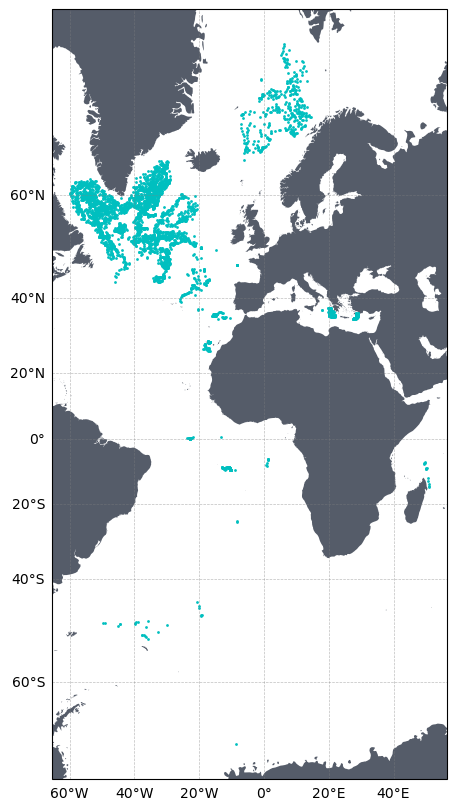

In [3]:
fig=plt.figure(figsize=(12,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.add_feature(land_feature, edgecolor=None)
ax.plot(gebco['lon'],gebco['lat'],'.c', markersize=4, markeredgecolor='None', alpha=1, transform=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER  

Text(0, 0.5, 'Bathy [m]')

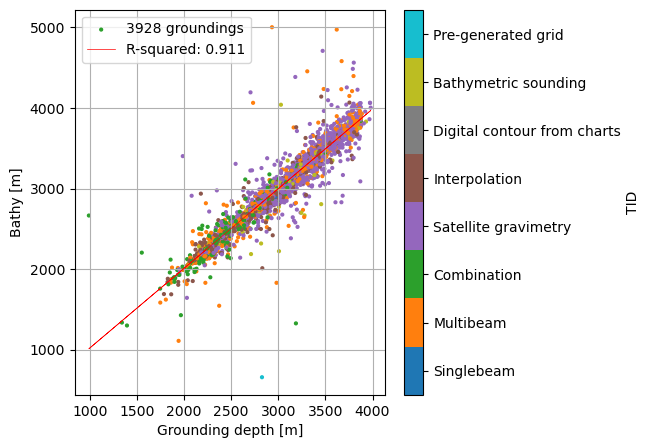

In [4]:
x=gebco['ground'].values
y=-gebco['gebco'].values
c=gebco['tid'].values
uc = np.unique(c)
sc = [tids[i] for i in uc]
cc = [np.argwhere(i==uc)[0].flatten() for i in c] 
res = stats.linregress(x, y)

fig,ax = plt.subplots(1,1,figsize=(5,5))
a=ax.scatter(x,y,s=4,c=cc,label=f"{len(x)} groundings",cmap=plt.get_cmap('tab10',len(uc)),vmin=0,vmax=8)
plt.plot(x, res.intercept + res.slope*x, 'r',linewidth=0.5,label=f"R-squared: {res.rvalue**2:.3f}")
cbar = plt.colorbar(a,label='TID')
cbar.set_ticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5],labels=sc)

#ax.set_xlim([1000,5000])
#ax.set_ylim([1000,5000])
ax.legend()
ax.set_xlabel('Grounding depth [m]')
ax.set_ylabel('Bathy [m]')
#fig.savefig('groundingVsBathy.png')

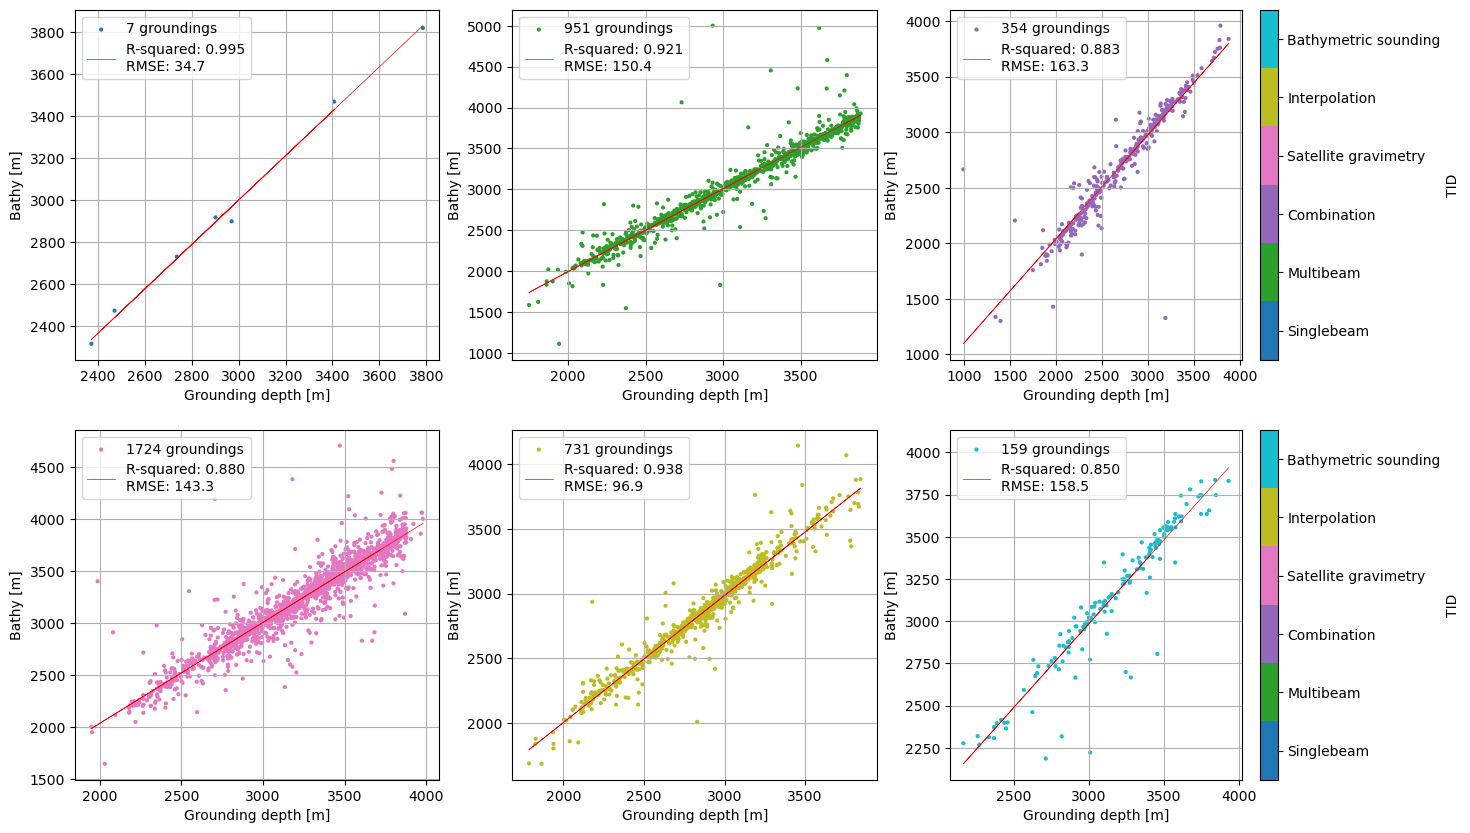

In [5]:
fig,ax = plt.subplots(2,3,figsize=(16,10))

uc = np.array([10,11,17,40,41,44]) #np.unique(c)
sc = [tids[i] for i in uc]

k=0
for t in uc:
    lk=int(np.floor(k/3))
    ck=k%3
    
    subgebco = gebco.query(f'tid=={t}')
    xs=subgebco['ground'].values
    ys=-subgebco['gebco'].values
    cs=subgebco['tid'].values    
    cc = [np.argwhere(i==uc)[0].flatten() for i in cs] 
    res = stats.linregress(xs, ys)

    a=ax[lk,ck].scatter(xs,ys,s=4,c=cc,label=f"{len(xs)} groundings",cmap=plt.get_cmap('tab10',len(uc)),vmin=0,vmax=6)
    ax[lk,ck].plot(xs, res.intercept + res.slope*xs, 'r',linewidth=0.5,label=f"R-squared: {res.rvalue**2:.3f}\nRMSE: {np.sqrt(mean_squared_error(ys, res.intercept + res.slope*xs)):.1f}")
    if ck==2:
        cbar = plt.colorbar(a,label='TID')
        cbar.set_ticks([0.5,1.5,2.5,3.5,4.5,5.5],labels=sc)
    
    ax[lk,ck].legend()
    ax[lk,ck].set_xlabel('Grounding depth [m]')
    ax[lk,ck].set_ylabel('Bathy [m]')
    k+=1

How to calculate the closest TID multibeam point to a lat/lon couple ?

In [28]:
mbgrid = xr.open_dataset('/home1/datawork/kbalem/GEBCO_2023_TID.nc')
df1 = xr.open_dataset('working_ds_2.nc')

## Smallest distance to a multibeam grid point ?

In [29]:
dist_to_mb = np.zeros(len(df1.N_GRD.values))*np.nan
tid_val = np.zeros(len(df1.N_GRD.values))*np.nan
#dist_to_mb = np.zeros(len(gebco))*np.nan

delta_deg = [1,2,3,4,5]
for i in range(len(dist_to_mb)):
    lat, lon = df1.isel(N_GRD=i)['LATITUDE'].values, df1.isel(N_GRD=i)['LONGITUDE'].values
    #lat, lon = gebco['lat'].values[i], gebco['lon'].values[i] 
    #Select a subarray in gebco tid grid (from 1° to 10° if it does not find tid ==11)    
    tid_val[i] = mbgrid['tid'].interp(lon=lon,lat=lat,method='nearest').values
    for d in delta_deg:
        submgrid = mbgrid.sel(lon=slice(lon-d/2,lon+d/2),lat=slice(lat-d/2,lat+d/2))
        submgrid = submgrid.where(submgrid['tid']==11,drop=True)
        if len(submgrid.lon)>0:
            break     
    if len(submgrid.lon)==0:
        break        
    stacked_submgrid = submgrid.stack(k=('lat','lon'))
    stacked_submgrid = stacked_submgrid.dropna('k')
    around_points = np.column_stack([stacked_submgrid['lat'].values,stacked_submgrid['lon'].values])    
    result = haversine_distances(np.radians([lat,lon]).reshape(1, -1), np.radians(around_points))
    # multiply by Earth radius to get kilometers    
    dist_to_mb[i]=np.min(result)*6371000/1000

In [30]:
df1['mindist'] = xr.DataArray(dist_to_mb,dims='N_GRD')
df1['tid'] = xr.DataArray(tid_val,dims='N_GRD')

In [31]:
df1.to_netcdf('working_ds_2_tid_mindist_to_mb.nc')

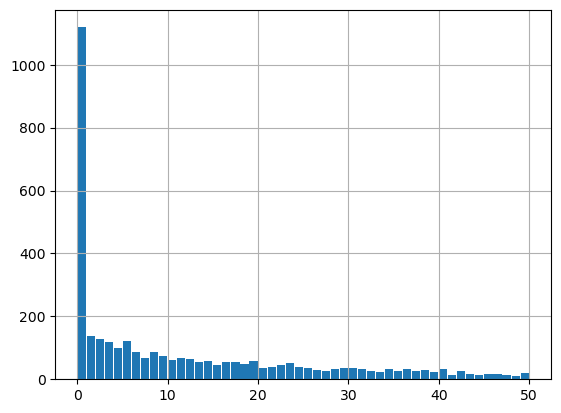

In [35]:
_ = plt.hist(dist_to_mb,bins=50,rwidth=0.9,range=[0,50])

In [20]:
indexz = np.argwhere((dist_to_mb>=5).astype(int)==1).flatten()

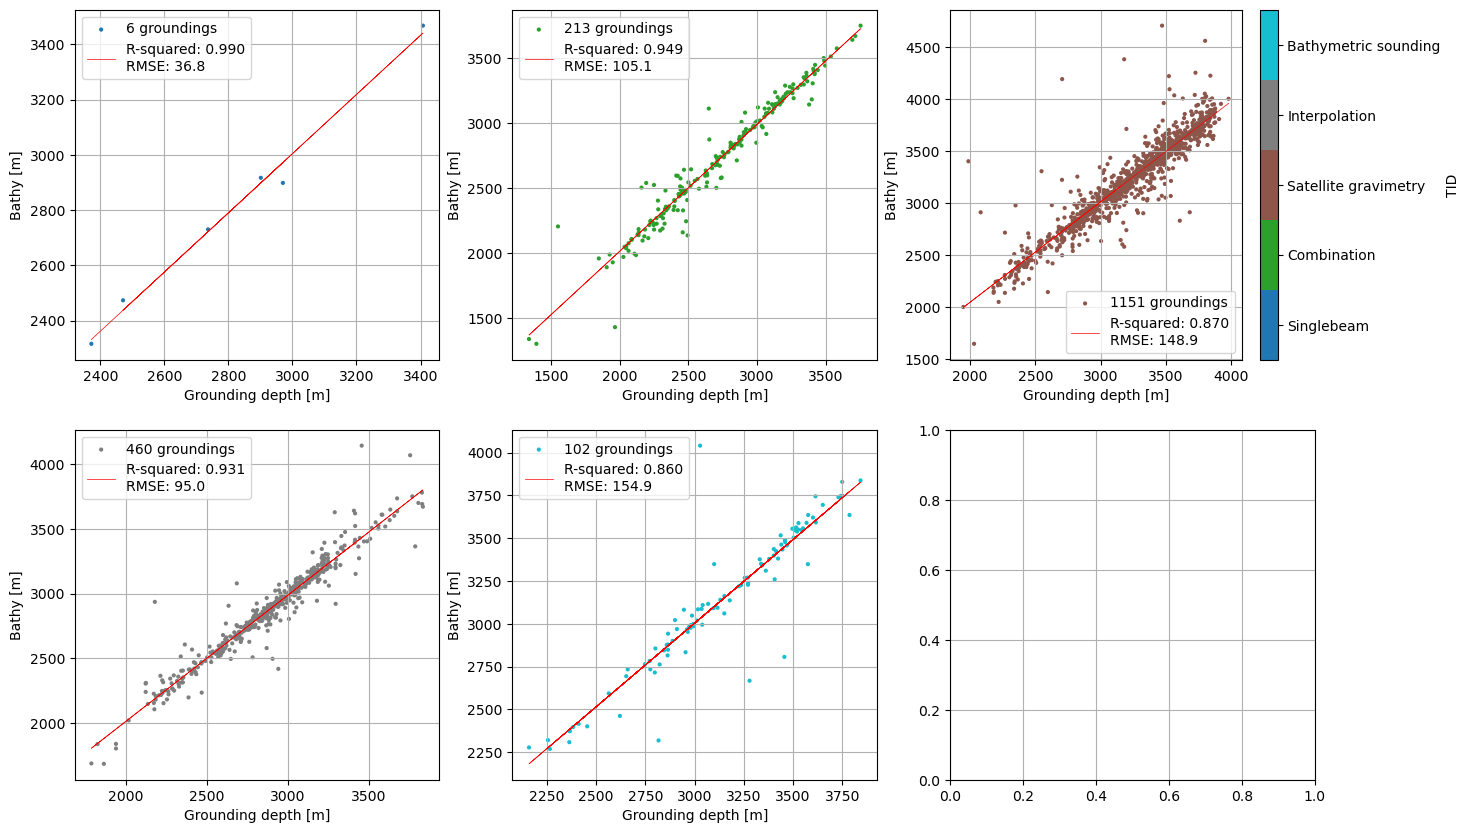

In [36]:
fig,ax = plt.subplots(2,3,figsize=(16,10))

uc = np.array([10, 17, 40, 41, 44]) #np.unique(c)
sc = [tids[i] for i in uc]

k=0
for t in uc:
    lk=int(np.floor(k/3))
    ck=k%3
    #HERE WE TAKE ONLY THE INDEXZ VALUES
    subgebco = gebco.iloc[indexz].query(f'tid=={t}')
    xs=subgebco['ground'].values
    ys=-subgebco['gebco'].values
    cs=subgebco['tid'].values    
    cc = [np.argwhere(i==uc)[0].flatten() for i in cs] 
    res = stats.linregress(xs, ys)

    a=ax[lk,ck].scatter(xs,ys,s=4,c=cc,label=f"{len(xs)} groundings",cmap=plt.get_cmap('tab10',len(uc)),vmin=0,vmax=5)
    ax[lk,ck].plot(xs, res.intercept + res.slope*xs, 'r',linewidth=0.5,label=f"R-squared: {res.rvalue**2:.3f}\nRMSE: {np.sqrt(mean_squared_error(ys, res.intercept + res.slope*xs)):.1f}")
    if ck==2:
        cbar = plt.colorbar(a,label='TID')
        cbar.set_ticks([0.5,1.5,2.5,3.5,4.5],labels=sc)
    
    ax[lk,ck].legend()
    ax[lk,ck].set_xlabel('Grounding depth [m]')
    ax[lk,ck].set_ylabel('Bathy [m]')
    k+=1

In [43]:
last = df1.where((df1['tid']==40)&(df1['mindist']>=10),drop=True) 
last

<xarray.Dataset>
Dimensions:          (N_GRD: 1097)
Dimensions without coordinates: N_GRD
Data variables: (12/16)
    LATITUDE         (N_GRD) float64 46.18 45.3 52.74 52.63 ... 58.4 53.65 50.77
    LONGITUDE        (N_GRD) float64 -19.78 -23.45 -35.53 ... -26.4 -31.44
    PROFILER_TYPE    (N_GRD) float64 838.0 838.0 838.0 ... 838.0 838.0 838.0
    CYCLE_NUMBER     (N_GRD) float64 48.0 128.0 1.0 1.0 ... 91.0 56.0 17.0 121.0
    WMO              (N_GRD) float64 6.902e+06 6.902e+06 ... 6.991e+06 6.903e+06
    GROUNDING_DEPTH  (N_GRD) float64 3.791e+03 3.196e+03 ... 3.662e+03 3.721e+03
    ...               ...
    etopo_max        (N_GRD) float64 4.61e+03 3.192e+03 ... 3.641e+03 3.666e+03
    gebco_min        (N_GRD) float64 4.197e+03 3.022e+03 ... 3.64e+03 3.619e+03
    gebco_max        (N_GRD) float64 4.658e+03 3.245e+03 ... 3.659e+03 3.663e+03
    l389             (N_GRD) float64 17.0 14.0 9.0 9.0 8.0 ... 9.0 8.0 9.0 10.0
    mindist          (N_GRD) float64 39.18 16.94 20.99 ... 31.92 73.93 22.37
    tid              (N_GRD) float64 40.0 40.0 40.0 40.0 ... 40.0 40.0 40.0 40.0

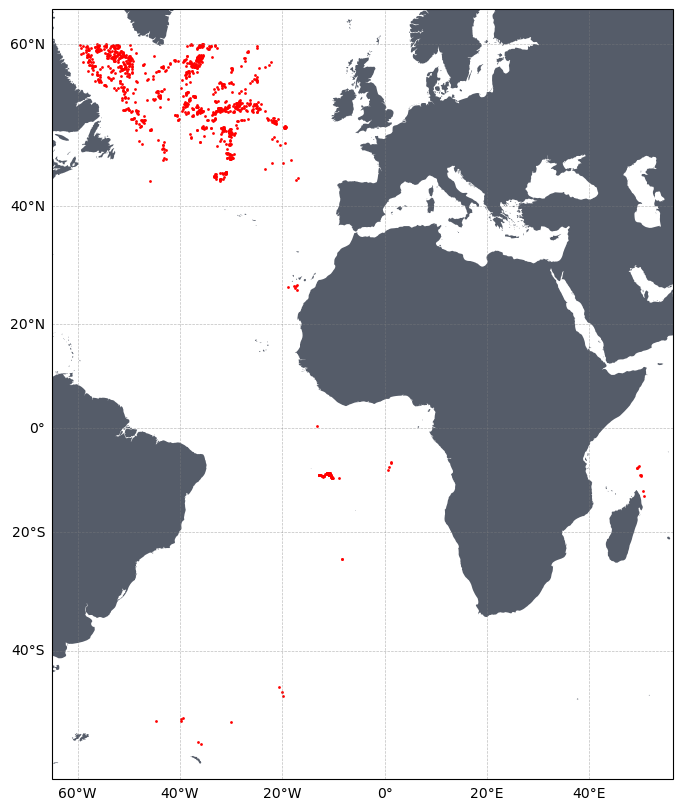

In [44]:
fig=plt.figure(figsize=(12,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.add_feature(land_feature, edgecolor=None)
ax.plot(last['LONGITUDE'],last['LATITUDE'],'.r', markersize=4, markeredgecolor='None', alpha=1, transform=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER  